In [39]:
import pandas as pd
import numpy as np
import re
import unicodedata

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Carga de datos de IPM
df_IPM = pd.read_csv('data/Hogares_IPM_2018.csv', sep=";")
df_IPM.head()
df_IPM["ipm"] = df_IPM["ipm"].str.replace(",", ".").astype(float)
IPM_DEPARTAMENTOS = df_IPM.groupby('DEPARTAMENTO')['ipm'].mean().reset_index()
IPM_DEPARTAMENTOS

,DEPARTAMENTO,ipm
0,5,0.212018
1,8,0.230189
2,11,0.158780
3,13,0.265944
4,15,0.211427
5,17,0.207054
6,18,0.246883
7,19,0.229898
8,20,0.261580
9,23,0.264616


In [ ]:
# Normalizar la tabla de IPM departamental ---
# df_ipm: columnas originales -> 'DEPARTAMENTO' (código depto) e 'ipm'
ipm_depto_df = IPM_DEPARTAMENTOS.rename(columns={'DEPARTAMENTO': 'dept_code', 'ipm': 'ipm_depto'}).copy()
ipm_depto_df['dept_code'] = pd.to_numeric(ipm_depto_df['dept_code'], errors='coerce').astype('Int64')

df_CNC = pd.read_excel('data/CNC_2018.xlsx')
# Partir del listado de municipios (PB)
muni_df = (
    df_CNC[['PB']].dropna().drop_duplicates().copy()
)

# Extraer código de departamento desde PB 
muni_df['dept_code'] = (
    muni_df['PB'].astype(str)
                 .str.extract(r'(\d+)')[0]   # solo dígitos
                 .str.zfill(5)               # asegurar 5 dígitos (DDMMM)
                 .str[:2]                    # tomar 2 primeros -> depto
                 .astype('Int64')
)
muni_df.reset_index(drop=True, inplace=True)


df_CNC_IPM = muni_df.merge(ipm_depto_df, on='dept_code', how='inner')

display(df_CNC_IPM)

,PB,dept_code,ipm_depto
0,8001,8,0.230189
1,5001,5,0.212018
2,68001,68,0.207674
3,11001,11,0.158780
4,54001,54,0.264164
5,76001,76,0.194793
6,13001,13,0.265944
7,70001,70,0.277548
8,23079,23,0.264616
9,70708,70,0.277548


In [ ]:
# Cargar nuevo dataset de penetración de internet fijo y hacer merge con CNC + IPM
internet = pd.read_csv("data/Internet_Fijo_Penetración_Municipio_20250826.csv")


# ensure numeric
internet['AÑO'] = pd.to_numeric(internet['AÑO'], errors='coerce')
internet['TRIMESTRE'] = pd.to_numeric(internet['TRIMESTRE'], errors='coerce')

# filter: Año = 2018 and TRIMESTRE = 4
internet_2018q4 = internet.loc[(internet['AÑO'] == 2018) & (internet['TRIMESTRE'] == 4)].copy()


display(internet.columns)

# Unir con el dataset de encuestas agregadas
df_CNC_IPM_PI = df_CNC_IPM.merge(
    internet_2018q4[["COD_MUNICIPIO", "INDICE"]],
    left_on="PB", right_on="COD_MUNICIPIO", how="inner"
)

display(df_CNC_IPM_PI)

Index(['AÑO', 'TRIMESTRE', 'COD_DEPARTAMENTO', 'DEPARTAMENTO', 'COD_MUNICIPIO',
       'MUNICIPIO', 'No. ACCESOS FIJOS A INTERNET', 'POBLACIÓN DANE',
       'INDICE'],
      dtype='object')

,PB,dept_code,ipm_depto,COD_MUNICIPIO,INDICE
0,8001,8,0.230189,8001,"15,81"
1,5001,5,0.212018,5001,"24,42"
2,68001,68,0.207674,68001,"24,13"
3,11001,11,0.158780,11001,"25,31"
4,54001,54,0.264164,54001,"13,90"
5,76001,76,0.194793,76001,"21,38"
6,13001,13,0.265944,13001,"15,48"
7,70001,70,0.277548,70001,"13,30"
8,23079,23,0.264616,23079,"0,56"
9,70708,70,0.277548,70708,"1,96"


In [ ]:
# Cargar datos de examen saber 11

saber = pd.read_csv("data/Examen_Saber_11_20181.txt", sep=";", usecols=["estu_cod_reside_mcpio","punt_global"], low_memory=False)

icfes_prom_muni = (
    saber.dropna(subset=["estu_cod_reside_mcpio", "punt_global"])
         .groupby("estu_cod_reside_mcpio", as_index=False)["punt_global"]
         .mean()
         .rename(columns={"punt_global": "saber_punt_global_mean"})
)



df_CNC_IPM_PI_SABER = df_CNC_IPM_PI.merge(
    icfes_prom_muni[["estu_cod_reside_mcpio", "saber_punt_global_mean"]],
    left_on="PB", right_on="estu_cod_reside_mcpio", how="inner"
)

df_maestro_global_variables_munnicipio = df_CNC_IPM_PI_SABER[["PB","dept_code","ipm_depto","INDICE","saber_punt_global_mean"]]

display(df_maestro_global_variables_munnicipio)

,PB,dept_code,ipm_depto,INDICE,saber_punt_global_mean
0,8001,8,0.230189,"15,81",286.622745
1,5001,5,0.212018,"24,42",256.242312
2,68001,68,0.207674,"24,13",302.117450
3,11001,11,0.158780,"25,31",288.624269
4,54001,54,0.264164,"13,90",258.778450
5,76001,76,0.194793,"21,38",291.885904
6,13001,13,0.265944,"15,48",252.610512
7,70001,70,0.277548,"13,30",247.569620
8,23079,23,0.264616,"0,56",244.000000
9,70708,70,0.277548,"1,96",237.125000


In [ ]:
# Obtener variables de interés del dataset CNC original

df_CNC_vars_interes = df_CNC[['PB','INDICADOR','NIVEL_PIRAMIDE','RANGO_EDAD','PB1','SEXO','ESTRATO','P33']].copy()
df_CNC_vars_interes.fillna({'P33': 0}, inplace=True)

#validar is hay nulos en las variables de interés
na_counts = df_CNC_vars_interes.isna().sum().sort_values(ascending=False)
na_pct = (df_CNC_vars_interes.isna().mean() * 100).round(2)
na_report = (
    pd.DataFrame({'n_nulls': na_counts, 'pct_nulls': na_pct})
      .sort_values('n_nulls', ascending=False)
)
display(na_report)

,n_nulls,pct_nulls
PB,0,0.0
INDICADOR,0,0.0
NIVEL_PIRAMIDE,0,0.0
RANGO_EDAD,0,0.0
PB1,0,0.0
SEXO,0,0.0
ESTRATO,0,0.0
P33,0,0.0


In [8]:
display(df_CNC_vars_interes)

df_modelo = df_CNC_vars_interes.merge(
    df_maestro_global_variables_munnicipio,
    on="PB", how="inner"
)

df_modelo = df_modelo.drop("dept_code", axis=1)
display(df_modelo)

,PB,INDICADOR,NIVEL_PIRAMIDE,RANGO_EDAD,PB1,SEXO,ESTRATO,P33
0,8001,0.000000,0,7,1,2,2,0.0
1,5001,0.000000,0,6,1,2,2,0.0
2,5001,0.000000,0,6,1,2,2,0.0
3,5001,0.076923,1,4,1,1,2,1.0
4,68001,0.461538,2,4,1,1,2,2.0
...,...,...,...,...,...,...,...,...
3478,81001,0.076923,1,2,2,2,1,4.0
3479,81001,0.000000,0,4,2,1,1,6.0
3480,81001,0.000000,0,2,2,1,1,6.0
3481,81001,0.230769,2,3,1,2,1,1.0


,PB,INDICADOR,NIVEL_PIRAMIDE,RANGO_EDAD,PB1,SEXO,ESTRATO,P33,ipm_depto,INDICE,saber_punt_global_mean
0,8001,0.000000,0,7,1,2,2,0.0,0.230189,"15,81",286.622745
1,5001,0.000000,0,6,1,2,2,0.0,0.212018,"24,42",256.242312
2,5001,0.000000,0,6,1,2,2,0.0,0.212018,"24,42",256.242312
3,5001,0.076923,1,4,1,1,2,1.0,0.212018,"24,42",256.242312
4,68001,0.461538,2,4,1,1,2,2.0,0.207674,"24,13",302.117450
...,...,...,...,...,...,...,...,...,...,...,...
3478,81001,0.076923,1,2,2,2,1,4.0,0.246648,"7,99",247.956044
3479,81001,0.000000,0,4,2,1,1,6.0,0.246648,"7,99",247.956044
3480,81001,0.000000,0,2,2,1,1,6.0,0.246648,"7,99",247.956044
3481,81001,0.230769,2,3,1,2,1,1.0,0.246648,"7,99",247.956044


In [ ]:
# Preparación de datos
df = df_modelo.copy()

# Arreglar posibles comas decimales en 'INDICE'
if df['INDICE'].dtype == 'object':
    df['INDICE'] = pd.to_numeric(df['INDICE'].astype(str).str.replace(',', '.', regex=False), errors='coerce')

cols_to_num = [
    'RANGO_EDAD','PB1','SEXO','ESTRATO','P33',
    'ipm_depto','INDICE','saber_punt_global_mean'
]
for c in cols_to_num:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Binarizar variables binarias
df['PB1_bin']  = (df['PB1'] == 1).astype(int)   # 1=Urbana
df['SEXO_bin'] = (df['SEXO'] == 1).astype(int)  # 1=Masculino

# Target y grupos
y = pd.to_numeric(df['INDICADOR'], errors='coerce')
groups = df['PB']

# Features
num_feats = [
    'RANGO_EDAD','ESTRATO','PB1_bin','SEXO_bin',
    'P33','ipm_depto','INDICE','saber_punt_global_mean'
]
cat_feats = ['dept_code'] if 'dept_code' in df.columns else []

X = df[num_feats + cat_feats].copy()



# 1) Preprocesamiento
pre = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), num_feats),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
    ],
    remainder='drop'
)

# 2) logit del target
eps = 1e-6
def to_logit(y_arr):
    z = np.clip(np.asarray(y_arr, dtype=float), eps, 1 - eps)
    return np.log(z / (1 - z))

def inv_logit(z):
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

# 3) Definición de CV y grids
n_groups = groups.nunique()
n_splits = min(5, n_groups) if n_groups >= 2 else 2
cv = GroupKFold(n_splits=n_splits)

grid_ridge = {'model__alpha': np.r_[np.logspace(-6, -3, 7), np.logspace(-3, 3, 13)]}  # más fino en alfas chicas
grid_lasso = {'model__alpha': np.logspace(-4, 1, 12)}
grid_enet  = {
    'model__alpha':    np.logspace(-4, 1, 12),
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
# para el caso logit cambia el nombre del paso a 'reg__regressor__param'
grid_enet_logit = {
    'reg__regressor__alpha':    np.logspace(-4, 1, 12),
    'reg__regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# 4) función de evaluación genérica
def eval_model(name, pipeline, param_grid, use_groups=True):
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=cv if use_groups else 5,
        scoring={'mae':'neg_mean_absolute_error', 'r2':'r2'},
        refit='mae',
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X, y, groups=groups if use_groups else None)
    idx = gs.best_index_
    res = {
        'modelo': name,
        'best_params': gs.best_params_,
        'cv_mae': -gs.best_score_,
        'cv_r2': gs.cv_results_['mean_test_r2'][idx],
        'best_estimator': gs.best_estimator_
    }
    print(f"{name:24s} | MAE={res['cv_mae']:.4f} | R²={res['cv_r2']:.4f} | {res['best_params']}")
    return res

# 5) Modelos a comparar
models_results = []

# Baseline (promedio) para referencia
baseline = Pipeline([('pre', pre), ('model', DummyRegressor(strategy='mean'))])
base_res = eval_model("Baseline (mean)", baseline, param_grid={}, use_groups=True)
models_results.append(base_res)

# ridge (identidad)
ridge = Pipeline([('pre', pre), ('model', Ridge(random_state=42))])
models_results.append(eval_model("Ridge (L2, identidad)", ridge, grid_ridge, use_groups=True))

# Lasso (identidad)
lasso = Pipeline([('pre', pre), ('model', Lasso(random_state=42, max_iter=20000))])
models_results.append(eval_model("Lasso (L1, identidad)", lasso, grid_lasso, use_groups=True))

# Elastic Net (identidad)
enet = Pipeline([('pre', pre), ('model', ElasticNet(random_state=42, max_iter=20000))])
models_results.append(eval_model("ElasticNet (identidad)", enet, grid_enet, use_groups=True))

# Elastic Net con logit del target
enet_logit = Pipeline([
    ('pre', pre),
    ('reg', TransformedTargetRegressor(
        regressor=ElasticNet(random_state=42, max_iter=20000),
        func=to_logit, inverse_func=inv_logit,
        check_inverse=False
    ))
])
models_results.append(eval_model("ElasticNet (logit target)", enet_logit, grid_enet_logit, use_groups=True))

# 6) Tabla comparativa
tabla = (pd.DataFrame(models_results)
           .drop(columns=['best_estimator'])
           .sort_values('cv_mae')
           .reset_index(drop=True))
display(tabla)

# Tomar el mejor y ver importancia por coef
mejor = min(models_results, key=lambda d: d['cv_mae'])['best_estimator']
if 'model' in mejor.named_steps and hasattr(mejor['model'], 'coef_'):
    feat_names = mejor['pre'].get_feature_names_out()
    coefs = mejor['model'].coef_
    imp = (pd.DataFrame({'feature': feat_names, 'importance': np.abs(coefs), 'coef': coefs})
             .sort_values('importance', ascending=False))
    print("\nTop 15 features por |coef| (modelo ganador):")
    display(imp.head(15))
elif 'reg' in mejor.named_steps:  # caso logit
    feat_names = mejor['pre'].get_feature_names_out()
    coefs = mejor['reg'].regressor_.coef_
    imp = (pd.DataFrame({'feature': feat_names, 'importance': np.abs(coefs), 'coef': coefs})
             .sort_values('importance', ascending=False))
    print("\nTop 15 features por |coef| (modelo ganador, logit-space):")
    display(imp.head(15))


Baseline (mean)          | MAE=0.1796 | R²=-0.0371 | {}
Ridge (L2, identidad)    | MAE=0.1560 | R²=0.1246 | {'model__alpha': np.float64(1e-06)}
Lasso (L1, identidad)    | MAE=0.1554 | R²=0.1315 | {'model__alpha': np.float64(0.002310129700083158)}
ElasticNet (identidad)   | MAE=0.1554 | R²=0.1313 | {'model__alpha': np.float64(0.002310129700083158), 'model__l1_ratio': 0.9}
ElasticNet (logit target) | MAE=0.1691 | R²=-0.3984 | {'reg__regressor__alpha': np.float64(0.4328761281083057), 'reg__regressor__l1_ratio': 0.7}


,modelo,best_params,cv_mae,cv_r2
0,"Lasso (L1, identidad)",{'model__alpha': 0.002310129700083158},0.155419,0.131516
1,ElasticNet (identidad),"{'model__alpha': 0.002310129700083158, 'model_...",0.155426,0.131338
2,"Ridge (L2, identidad)",{'model__alpha': 1e-06},0.156013,0.124646
3,ElasticNet (logit target),"{'reg__regressor__alpha': 0.4328761281083057, ...",0.169082,-0.398424
4,Baseline (mean),{},0.179557,-0.037064



Top 15 features por |coef| (modelo ganador):


,feature,importance,coef
0,num__RANGO_EDAD,0.084191,-0.084191
1,num__ESTRATO,0.043056,0.043056
5,num__ipm_depto,0.021453,-0.021453
4,num__P33,0.017302,-0.017302
3,num__SEXO_bin,0.011007,0.011007
6,num__INDICE,0.006857,0.006857
7,num__saber_punt_global_mean,0.004944,0.004944
2,num__PB1_bin,0.001574,0.001574


In [ ]:

df = df_modelo.copy()

# Fix
if df['INDICE'].dtype == 'object':
    df['INDICE'] = pd.to_numeric(df['INDICE'].astype(str).str.replace(',', '.', regex=False), errors='coerce')

to_num = ['RANGO_EDAD','PB1','SEXO','ESTRATO','P33','ipm_depto','INDICE','saber_punt_global_mean']
for c in to_num:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Binarios
df['PB1_bin']  = (df['PB1'] == 1).astype(int)   # 1=Urbana
df['SEXO_bin'] = (df['SEXO'] == 1).astype(int)  # 1=Masculino

# 1) Features/target (sin NIVEL_PIRAMIDE)
num_feats = [
    'RANGO_EDAD','ESTRATO','PB1_bin','SEXO_bin',
    'P33','ipm_depto','INDICE','saber_punt_global_mean'
]
cat_feats = ['dept_code'] if 'dept_code' in df.columns else []

X = df[num_feats + cat_feats].copy()
y = pd.to_numeric(df['INDICADOR'], errors='coerce')  # in [0,1]
groups = df['PB']

# Drop rows with missing y
mask = y.notna() & groups.notna()
X, y, groups = X.loc[mask], y.loc[mask], groups.loc[mask]

# 2) Preprocessing
pre = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
], remainder='drop')

# 3) Logit transform for the target wit TransformedTargetRegressor
eps = 1e-6
def to_logit(y_arr):
    z = np.clip(y_arr, eps, 1 - eps)
    return np.log(z / (1 - z))

def inv_logit(z):
    return 1.0 / (1.0 + np.exp(-z))

enet = ElasticNet(random_state=42, max_iter=20000)
reg = TransformedTargetRegressor(regressor=enet, func=to_logit, inverse_func=inv_logit, check_inverse=False)

pipe = Pipeline([
    ('pre', pre),
    ('reg', reg)
])

# 4) CV & hyperparam search
n_groups = groups.nunique()
n_splits = min(5, n_groups) if n_groups >= 2 else 2
cv = GroupKFold(n_splits=n_splits)

param_grid = {
    'reg__regressor__alpha':     np.logspace(-4, 1, 12),   # 1e-4 .. 10
    'reg__regressor__l1_ratio':  [0.1, 0.3, 0.5, 0.7, 0.9]
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=cv,
    scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2'},
    refit='mae',
    n_jobs=-1,
    verbose=0
)

grid.fit(X, y, groups=groups)

best = grid.best_estimator_
best_alpha = grid.best_params_['reg__regressor__alpha']
best_l1r   = grid.best_params_['reg__regressor__l1_ratio']
best_idx   = grid.best_index_
cv_mae     = -grid.best_score_
cv_r2      = grid.cv_results_['mean_test_r2'][best_idx]

print(f"ElasticNet (logit target) -> best alpha: {best_alpha:.6f}, l1_ratio: {best_l1r:.2f} | "
      f"CV MAE: {cv_mae:.4f} | CV R²: {cv_r2:.4f}")

# 5) Inspect coefficients
feat_names = best['pre'].get_feature_names_out()
coefs = best['reg'].regressor_.coef_   # coefficients of ElasticNet in logit space
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs}) \
            .sort_values(by='coef', key=np.abs, ascending=False)
display(coef_df)

# 6) Predict
y_hat = best.predict(X)  # already inverse-transformed by TTR
mae_full = np.mean(np.abs(y - y_hat))
r2_full  = 1 - ((y - y_hat)**2).sum() / ((y - y.mean())**2).sum()
print(f"In-sample MAE: {mae_full:.4f} | R²: {r2_full:.4f}")

ElasticNet (logit target) -> best alpha: 0.432876, l1_ratio: 0.70 | CV MAE: 0.1691 | CV R²: -0.3984


,feature,coef
0,num__RANGO_EDAD,-2.498726
1,num__ESTRATO,0.785599
7,num__saber_punt_global_mean,0.217587
2,num__PB1_bin,0.084513
6,num__INDICE,0.077898
5,num__ipm_depto,-0.012109
3,num__SEXO_bin,0.000000
4,num__P33,0.000000


In-sample MAE: 0.1667 | R²: -0.3455


In [ ]:
# Evaluación de Random Forest y XGBoost
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# grids
grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid_xgb = {
    'model__n_estimators': [25, 50, 100, 200],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__subsample': [0.8, 1.0]
}


# Random Forest (identidad)
rf = Pipeline([('pre', pre), ('model', RandomForestRegressor(random_state=42, n_jobs=-1))])
models_results.append(eval_model("RandomForest (identidad)", rf, grid_rf, use_groups=True))

# XGBoost (identidad)
xgb_model = Pipeline([('pre', pre), ('model', xgb.XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1))])
models_results.append(eval_model("XGBoost (identidad)", xgb_model, grid_xgb, use_groups=True))


# Random Forest con logit del target
rf_logit = Pipeline([
    ('pre', pre),
    ('reg', TransformedTargetRegressor(
        regressor=RandomForestRegressor(random_state=42, n_jobs=-1),
        func=to_logit, inverse_func=inv_logit, check_inverse=False
    ))
])
# Adjust grid for logit version
grid_rf_logit = {
    'reg__regressor__n_estimators': [50, 100, 200],
    'reg__regressor__max_depth': [None, 10, 20],
    'reg__regressor__min_samples_split': [2, 5],
    'reg__regressor__min_samples_leaf': [1, 2]
}
models_results.append(eval_model("RandomForest (logit target)", rf_logit, grid_rf_logit, use_groups=True))

# XGBoost con logit del target
xgb_logit = Pipeline([
    ('pre', pre),
    ('reg', TransformedTargetRegressor(
        regressor=xgb.XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1),
        func=to_logit, inverse_func=inv_logit, check_inverse=False
    ))
])
# Adjust grid for logit version
grid_xgb_logit = {
    'reg__regressor__n_estimators': [25, 50, 100, 200],
    'reg__regressor__max_depth': [3, 6, 9],
    'reg__regressor__learning_rate': [0.01, 0.1, 0.3],
    'reg__regressor__subsample': [0.8, 1.0]
}
models_results.append(eval_model("XGBoost (logit target)", xgb_logit, grid_xgb_logit, use_groups=True))

# tabla
tabla = (pd.DataFrame(models_results)
           .drop(columns=['best_estimator'])
           .sort_values('cv_mae')
           .reset_index(drop=True))
display(tabla)

# Tomar el mejor y ver importancia
mejor = min(models_results, key=lambda d: d['cv_mae'])['best_estimator']
if 'model' in mejor.named_steps and hasattr(mejor['model'], 'feature_importances_'):
    feat_names = mejor['pre'].get_feature_names_out()
    imps = mejor['model'].feature_importances_
    imp = (pd.DataFrame({'feature': feat_names, 'importance': imps})
             .sort_values('importance', ascending=False))
    print("\nTop 15 features por importance (modelo ganador):")
    display(imp.head(15))
elif 'reg' in mejor.named_steps and hasattr(mejor['reg'].regressor_, 'feature_importances_'):
    feat_names = mejor['pre'].get_feature_names_out()
    imps = mejor['reg'].regressor_.feature_importances_
    imp = (pd.DataFrame({'feature': feat_names, 'importance': imps})
             .sort_values('importance', ascending=False))
    print("\nTop 15 features por importance (modelo ganador, logit-space):")
    display(imp.head(15))
elif 'model' in mejor.named_steps and hasattr(mejor['model'], 'coef_'):
    pass

RandomForest (identidad) | MAE=0.1274 | R²=0.3002 | {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
XGBoost (identidad)      | MAE=0.1287 | R²=0.3091 | {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 1.0}
RandomForest (logit target) | MAE=0.1261 | R²=0.1988 | {'reg__regressor__max_depth': 10, 'reg__regressor__min_samples_leaf': 2, 'reg__regressor__min_samples_split': 5, 'reg__regressor__n_estimators': 100}
XGBoost (logit target)   | MAE=0.1228 | R²=0.2122 | {'reg__regressor__learning_rate': 0.1, 'reg__regressor__max_depth': 3, 'reg__regressor__n_estimators': 50, 'reg__regressor__subsample': 0.8}


,modelo,best_params,cv_mae,cv_r2
0,XGBoost (logit target),"{'reg__regressor__learning_rate': 0.1, 'reg__r...",0.122763,0.212214
1,RandomForest (logit target),"{'reg__regressor__max_depth': 10, 'reg__regres...",0.126057,0.198843
2,RandomForest (identidad),"{'model__max_depth': 10, 'model__min_samples_l...",0.127418,0.300192
3,XGBoost (identidad),"{'model__learning_rate': 0.1, 'model__max_dept...",0.128715,0.309132
4,"Lasso (L1, identidad)",{'model__alpha': 0.002310129700083158},0.155419,0.131516
5,ElasticNet (identidad),"{'model__alpha': 0.002310129700083158, 'model_...",0.155426,0.131338
6,"Ridge (L2, identidad)",{'model__alpha': 1e-06},0.156013,0.124646
7,ElasticNet (logit target),"{'reg__regressor__alpha': 0.4328761281083057, ...",0.169082,-0.398424
8,Baseline (mean),{},0.179557,-0.037064



Top 15 features por importance (modelo ganador, logit-space):


,feature,importance
4,num__P33,0.850139
0,num__RANGO_EDAD,0.033057
6,num__INDICE,0.030884
2,num__PB1_bin,0.022488
5,num__ipm_depto,0.022409
1,num__ESTRATO,0.016540
7,num__saber_punt_global_mean,0.014986
3,num__SEXO_bin,0.009497


In [13]:
from sklearn.svm import SVR

svr = Pipeline([
    ('pre', pre),
    ('model', SVR())
])

grid_svr = {
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__C': [0.1, 1, 10, 100],
    'model__epsilon': [0.01, 0.05, 0.1, 0.2]
}

models_results.append(eval_model("SVR", svr, grid_svr, use_groups=True))

SVR                      | MAE=0.1297 | R²=0.1928 | {'model__C': 0.1, 'model__epsilon': 0.01, 'model__kernel': 'rbf'}


In [ ]:
# kNN
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ('pre', pre),
    ('model', KNeighborsRegressor())
])

grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 15],
    'model__weights': ['uniform', 'distance']
}

models_results.append(eval_model("KNN Regressor", knn, grid_knn, use_groups=True))

KNN Regressor            | MAE=0.1479 | R²=0.1673 | {'model__n_neighbors': 15, 'model__weights': 'distance'}


In [15]:
# Gradient Boosting Regressor (GBR de sklearn)
from sklearn.ensemble import GradientBoostingRegressor

gbr = Pipeline([
    ('pre', pre),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid_gbr = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [2, 3, 4]
}

models_results.append(eval_model("GradientBoosting", gbr, grid_gbr, use_groups=True))

GradientBoosting         | MAE=0.1285 | R²=0.3054 | {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


In [16]:
# Convertir lista de resultados en DataFrame
df_resultados = pd.DataFrame(models_results)

# Ordenar por MAE (menor = mejor)
df_resultados = df_resultados.sort_values(by="cv_mae", ascending=True).reset_index(drop=True)

# Mostrar tabla comparativa
display(df_resultados[['modelo', 'cv_mae', 'cv_r2']])

,modelo,cv_mae,cv_r2
0,XGBoost (logit target),0.122763,0.212214
1,RandomForest (logit target),0.126057,0.198843
2,RandomForest (identidad),0.127418,0.300192
3,GradientBoosting,0.128487,0.305398
4,XGBoost (identidad),0.128715,0.309132
5,SVR,0.129725,0.192831
6,KNN Regressor,0.147912,0.167331
7,"Lasso (L1, identidad)",0.155419,0.131516
8,ElasticNet (identidad),0.155426,0.131338
9,"Ridge (L2, identidad)",0.156013,0.124646


In [26]:
def eval_model(name, pipeline, param_grid, X, y, groups, n_splits=5):
    cv = GroupKFold(n_splits=min(n_splits, groups.nunique()) if groups.nunique() >= 2 else 2)
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring={'mae':'neg_mean_absolute_error','rmse':'neg_root_mean_squared_error','r2':'r2'},
        refit='mae',
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X, y, groups=groups)
    idx = gs.best_index_
    res = {
        'modelo': name,
        'best_params': gs.best_params_,
        'cv_mae': -gs.best_score_,
        'cv_rmse': -gs.cv_results_['mean_test_rmse'][idx],
        'cv_r2': gs.cv_results_['mean_test_r2'][idx],
        'best_estimator': gs.best_estimator_,
        'cv': cv
    }
    print(f"{name:26s} | CV-MAE={res['cv_mae']:.4f} | CV-RMSE={res['cv_rmse']:.4f} | CV-R²={res['cv_r2']:.4f} | {res['best_params']}")
    return res

In [ ]:
# 5) Baseline + Lineales

models_results = []

baseline = Pipeline([('pre', pre), ('model', DummyRegressor(strategy='mean'))])
models_results.append(eval_model("Baseline (mean)", baseline, {}, X, y, groups))

ridge = Pipeline([('pre', pre), ('model', Ridge())])
models_results.append(eval_model("Ridge (L2)", ridge, {'model__alpha': np.logspace(-6, 3, 10)}, X, y, groups))

lasso = Pipeline([('pre', pre), ('model', Lasso(max_iter=20000))])
models_results.append(eval_model("Lasso (L1)", lasso, {'model__alpha': np.logspace(-4, 1, 12)}, X, y, groups))

enet = Pipeline([('pre', pre), ('model', ElasticNet(max_iter=20000))])
models_results.append(eval_model("ElasticNet", enet, {
    'model__alpha': np.logspace(-4, 1, 10),
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}, X, y, groups))

Baseline (mean)            | CV-MAE=0.1796 | CV-RMSE=0.2291 | CV-R²=-0.0371 | {}
Ridge (L2)                 | CV-MAE=0.1560 | CV-RMSE=0.2098 | CV-R²=0.1246 | {'model__alpha': np.float64(1e-06)}
Lasso (L1)                 | CV-MAE=0.1554 | CV-RMSE=0.2090 | CV-R²=0.1315 | {'model__alpha': np.float64(0.002310129700083158)}
ElasticNet                 | CV-MAE=0.1554 | CV-RMSE=0.2090 | CV-R²=0.1316 | {'model__alpha': np.float64(0.004641588833612782), 'model__l1_ratio': 0.5}


In [ ]:
# 6) Red neuronal (MLPRegressor) con GridSearch
from sklearn.neural_network import MLPRegressor

mlp = Pipeline([
    ('pre', pre),
    ('model', MLPRegressor(
        random_state=42,
        solver='adam',
        max_iter=2000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=30,
        learning_rate='adaptive',
        shuffle=True
    ))
])

grid_mlp = {
    'model__hidden_layer_sizes': [(64,), (128,), (64,32), (128,64), (64,64,32)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'model__learning_rate_init': [1e-3, 3e-3, 1e-2],
    'model__batch_size': [64, 128, 256]
}

mlp_res = eval_model("MLPRegressor (NN)", mlp, grid_mlp, X, y, groups)
models_results.append(mlp_res)

MLPRegressor (NN)          | CV-MAE=0.1273 | CV-RMSE=0.1845 | CV-R²=0.3214 | {'model__activation': 'relu', 'model__alpha': 0.01, 'model__batch_size': 64, 'model__hidden_layer_sizes': (64, 32), 'model__learning_rate_init': 0.01}


In [ ]:
# 7) Tabla comparativa (CV)

tabla = (pd.DataFrame(models_results)
           .drop(columns=['best_estimator','cv'])
           .sort_values('cv_mae')
           .reset_index(drop=True))
print("\n=== Resultados CV (ordenado por MAE) ===")
display(tabla)



=== Resultados CV (ordenado por MAE) ===


,modelo,best_params,cv_mae,cv_rmse,cv_r2
0,MLPRegressor (NN),"{'model__activation': 'relu', 'model__alpha': ...",0.127336,0.184545,0.321383
1,Lasso (L1),{'model__alpha': 0.002310129700083158},0.155419,0.208994,0.131516
2,ElasticNet,"{'model__alpha': 0.004641588833612782, 'model_...",0.155435,0.208991,0.131579
3,Ridge (L2),{'model__alpha': 1e-06},0.156013,0.209801,0.124646
4,Baseline (mean),{},0.179557,0.229087,-0.037064


In [ ]:
# 8) Métricas OOF del mejor modelo

winner = min(models_results, key=lambda d: d['cv_mae'])
best_est = winner['best_estimator']
cv_used  = winner['cv']

y_hat_oof = cross_val_predict(best_est, X, y, cv=cv_used, groups=groups, n_jobs=-1, method='predict')
oof_mae  = mean_absolute_error(y, y_hat_oof)
oof_rmse = root_mean_squared_error(y, y_hat_oof)
oof_r2   = r2_score(y, y_hat_oof)
print(f"\n== Mejor modelo: {winner['modelo']} ==")
print(f"OOF MAE : {oof_mae:.4f}")
print(f"OOF RMSE: {oof_rmse:.4f}")
print(f"OOF R²  : {oof_r2:.4f}")

# (Opcional) Recortar predicciones a [0,1] si requieres reportar en rango del indicador
y_hat_oof_clip = np.clip(y_hat_oof, 0, 1)
oof_mae_clip  = mean_absolute_error(y, y_hat_oof_clip)
oof_rmse_clip = root_mean_squared_error(y, y_hat_oof_clip)
oof_r2_clip   = r2_score(y, y_hat_oof_clip)
print(f"\nOOF (clipped a [0,1]) | MAE: {oof_mae_clip:.4f} | RMSE: {oof_rmse_clip:.4f} | R²: {oof_r2_clip:.4f}")


== Mejor modelo: MLPRegressor (NN) ==
OOF MAE : 0.1274
OOF RMSE: 0.1853
OOF R²  : 0.3468

OOF (clipped a [0,1]) | MAE: 0.1254 | RMSE: 0.1851 | R²: 0.3483


In [ ]:
# 9) Explicabilidad para la red

try:
    r = permutation_importance(
        best_est, X, y,
        scoring='neg_mean_absolute_error',
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    feat_names = best_est['pre'].get_feature_names_out()
    imp_nn = (pd.DataFrame({'feature': feat_names, 'importance': r.importances_mean})
                .sort_values('importance', ascending=False))
    print("\nTop 15 features (Permutation Importance) del modelo ganador:")
    display(imp_nn.head(15))
except Exception as e:
    print("Permutation importance no disponible:", e)


Top 15 features (Permutation Importance) del modelo ganador:


,feature,importance
4,num__P33,0.052922
0,num__RANGO_EDAD,0.008494
7,num__saber_punt_global_mean,0.005237
1,num__ESTRATO,0.004504
5,num__ipm_depto,0.003696
3,num__SEXO_bin,0.002086
6,num__INDICE,0.002052
2,num__PB1_bin,0.001266


In [ ]:
y_pred = y_hat_oof

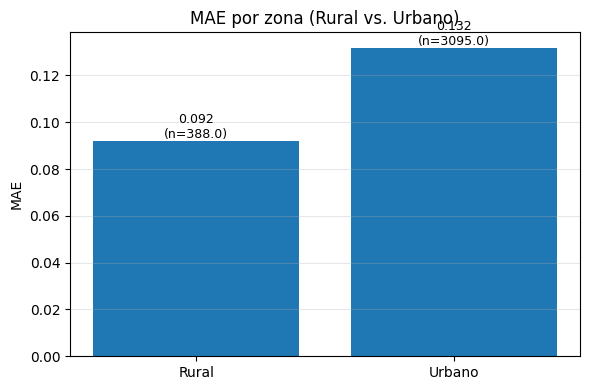

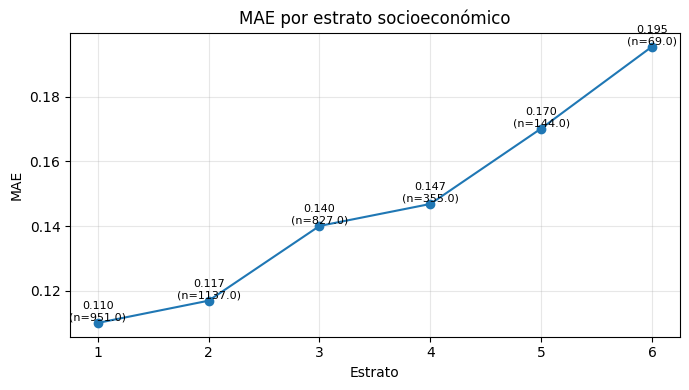

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1) Preparación del DataFrame de fairness

# y_true: df['INDICADOR']
# y_pred: vector/Serie con las predicciones (OOF preferible)
fair = df[['INDICADOR','PB1_bin','ESTRATO','ipm_depto']].copy()
fair = fair.rename(columns={'INDICADOR':'y_true'})
fair['y_pred'] = np.asarray(y_pred, dtype=float)

# Limpiezas y tipados seguros
fair['PB1_bin'] = pd.to_numeric(fair['PB1_bin'], errors='coerce').fillna(0).astype(int)
fair['ESTRATO'] = pd.to_numeric(fair['ESTRATO'], errors='coerce')
fair['ipm_depto'] = pd.to_numeric(
    fair['ipm_depto']
        .astype(str)
        .str.replace(',', '.', regex=False),
    errors='coerce'
)

# Mapea zona
fair['zona'] = fair['PB1_bin'].map({1:'Urbano', 0:'Rural'})

# 2) Helpers para MAE por subgrupo y por deciles de una var

def mae_por_grupo(df_in, group_col):
    out = (
        df_in.dropna(subset=['y_true','y_pred',group_col])
             .groupby(group_col)
             .apply(lambda g: pd.Series({
                 'MAE': mean_absolute_error(g['y_true'], g['y_pred']),
                 'N': len(g)
             }))
             .reset_index()
    )
    return out

def mae_por_deciles(df_in, col, q=10, labels=None):
    tmp = df_in.dropna(subset=['y_true','y_pred', col]).copy()
    tmp['decil'] = pd.qcut(tmp[col], q=q, labels=labels, duplicates='drop')
    out = (tmp.groupby('decil')
              .apply(lambda g: pd.Series({
                  'MAE': mean_absolute_error(g['y_true'], g['y_pred']),
                  'N': len(g),
                  col+'_mean': g[col].mean()
              }))
              .reset_index())
    return out


# 3) Gráfico: MAE Rural vs. Urbano

mae_zona = mae_por_grupo(fair, 'zona').sort_values('zona')
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(mae_zona['zona'], mae_zona['MAE'])
for x, y, n in zip(mae_zona['zona'], mae_zona['MAE'], mae_zona['N']):
    ax.text(x, y, f'{y:.3f}\n(n={n})', ha='center', va='bottom', fontsize=9)
ax.set_title('MAE por zona (Rural vs. Urbano)')
ax.set_ylabel('MAE')
ax.grid(axis='y', alpha=0.3)
fig.tight_layout()
plt.show()

# 4) Gráfico: MAE por Estrato

# Filtra estratos válidos (1..6, ajusta si tu codificación difiere)
fair_estr = fair[(fair['ESTRATO']>=1) & (fair['ESTRATO']<=6)].copy()
mae_estr = mae_por_grupo(fair_estr, 'ESTRATO').sort_values('ESTRATO')

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(mae_estr['ESTRATO'], mae_estr['MAE'], marker='o')
for x, y, n in zip(mae_estr['ESTRATO'], mae_estr['MAE'], mae_estr['N']):
    ax.text(x, y, f'{y:.3f}\n(n={n})', ha='center', va='bottom', fontsize=8)
ax.set_title('MAE por estrato socioeconómico')
ax.set_xlabel('Estrato')
ax.set_ylabel('MAE')
ax.set_xticks(sorted(mae_estr['ESTRATO'].unique()))
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

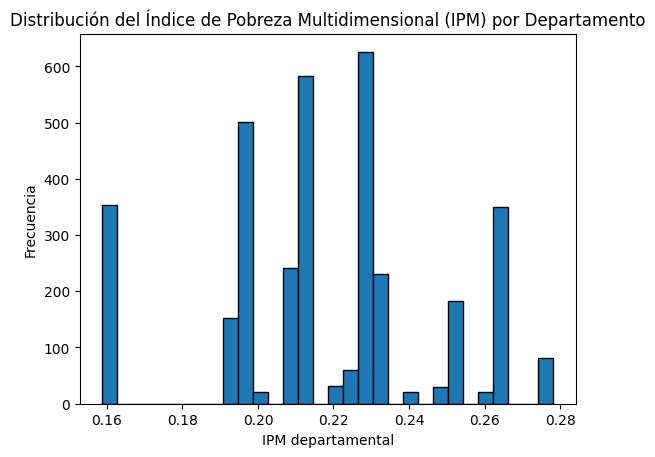

In [18]:
import matplotlib.pyplot as plt

plt.hist(df['ipm_depto'].dropna(), bins=30, edgecolor='black')
plt.title("Distribución del Índice de Pobreza Multidimensional (IPM) por Departamento")
plt.xlabel("IPM departamental")
plt.ylabel("Frecuencia")
plt.show()

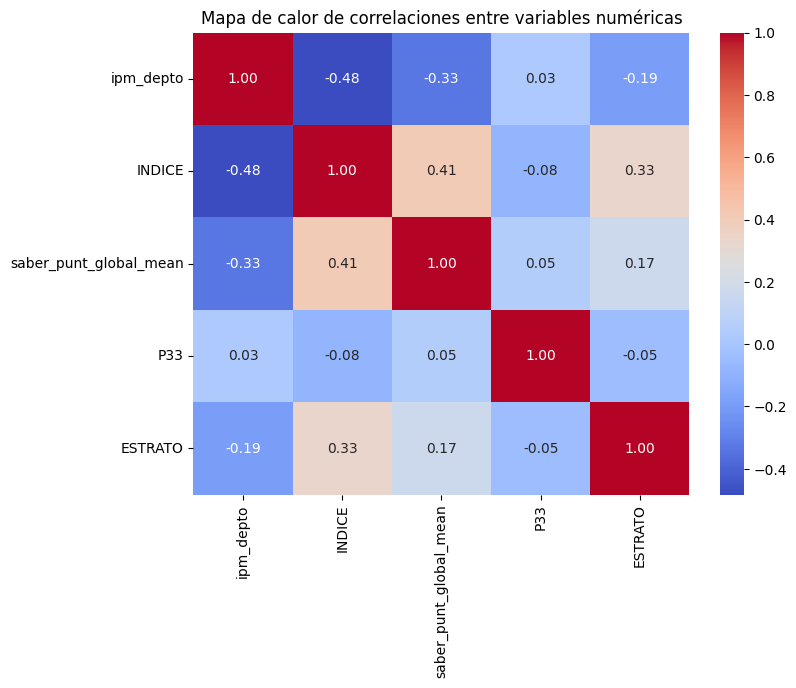

In [20]:
import seaborn as sns

plt.figure(figsize=(8,6))
corr = df[['ipm_depto','INDICE','saber_punt_global_mean','P33','ESTRATO']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.show()

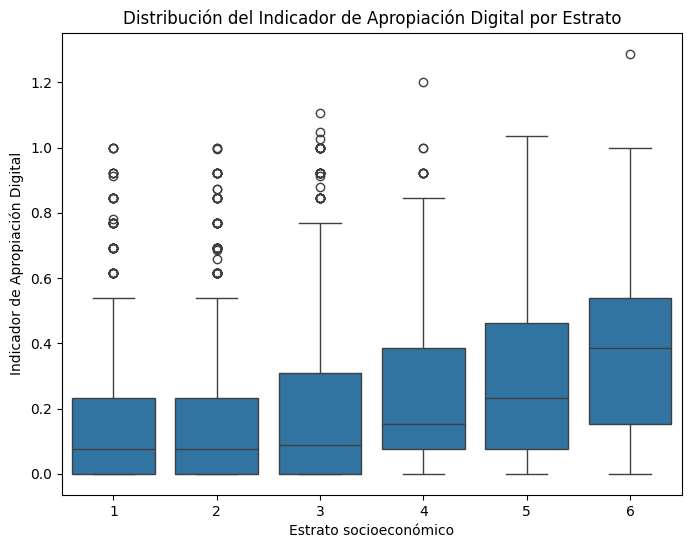

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='ESTRATO', y='INDICADOR', data=df)
plt.title("Distribución del Indicador de Apropiación Digital por Estrato")
plt.xlabel("Estrato socioeconómico")
plt.ylabel("Indicador de Apropiación Digital")
plt.show()

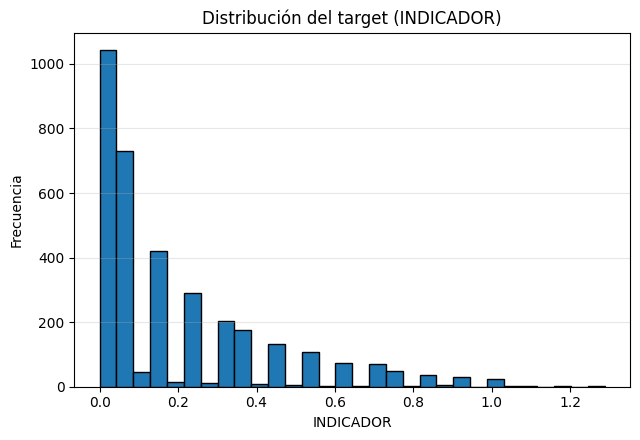

In [22]:
fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.hist(df['INDICADOR'].dropna(), bins=30, edgecolor='black')
ax.set_title('Distribución del target (INDICADOR)')
ax.set_xlabel('INDICADOR')
ax.set_ylabel('Frecuencia')
ax.grid(axis='y', alpha=0.3)
fig.tight_layout()
plt.show()

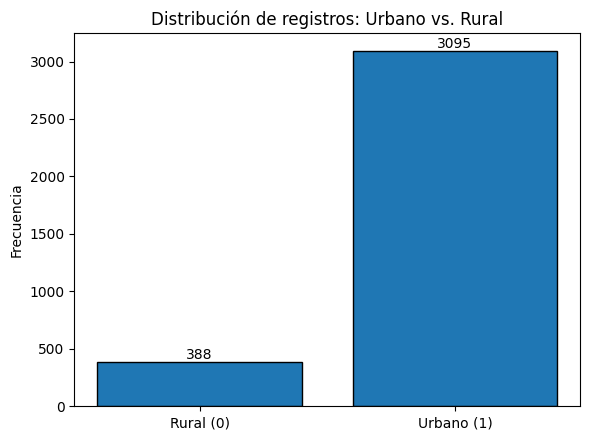

In [23]:
# Si no existe PB1_bin, crearlo (1=urbano vs 0=rural)
if 'PB1_bin' not in df:
    df['PB1_bin']  = (df['PB1'] == 1).astype(int)

counts_pb1 = df['PB1_bin'].value_counts().reindex([0,1]).fillna(0)

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.bar(['Rural (0)', 'Urbano (1)'], counts_pb1.values, edgecolor='black')
ax.set_title('Distribución de registros: Urbano vs. Rural')
ax.set_ylabel('Frecuencia')
for i, v in enumerate(counts_pb1.values):
    ax.text(i, v, f'{int(v)}', ha='center', va='bottom')
fig.tight_layout()
plt.show()

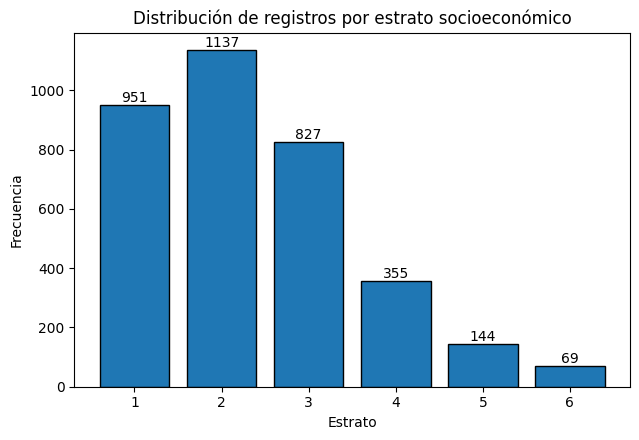

In [24]:
estrato_counts = df['ESTRATO'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.bar([str(int(e)) for e in estrato_counts.index], estrato_counts.values, edgecolor='black')
ax.set_title('Distribución de registros por estrato socioeconómico')
ax.set_xlabel('Estrato')
ax.set_ylabel('Frecuencia')
for i, v in enumerate(estrato_counts.values):
    ax.text(i, v, f'{int(v)}', ha='center', va='bottom')
fig.tight_layout()
plt.show()

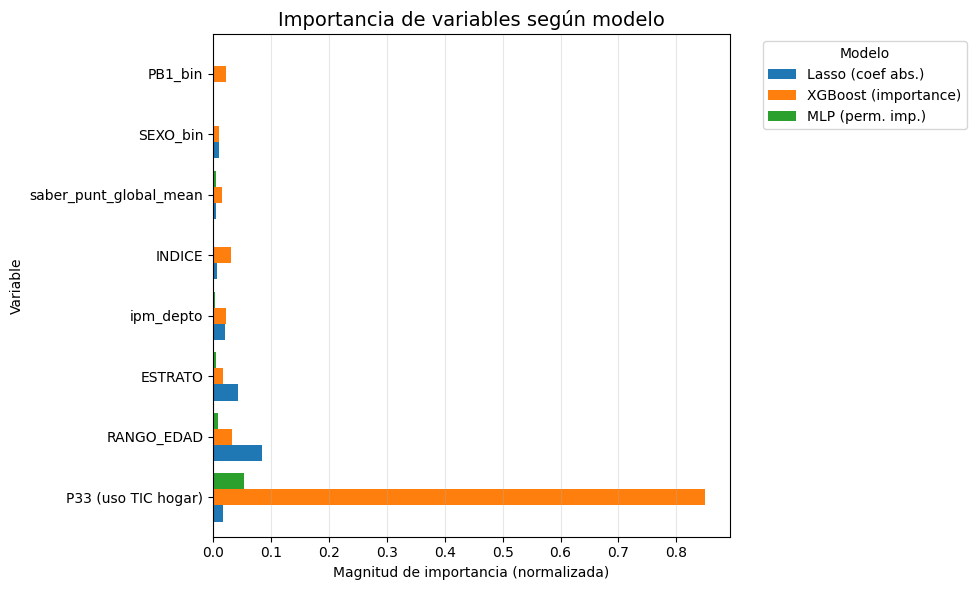

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# 1) DataFrame con importancias

data = {
    "Variable": [
        "P33 (uso TIC hogar)", "RANGO_EDAD", "ESTRATO",
        "ipm_depto", "INDICE", "saber_punt_global_mean",
        "SEXO_bin", "PB1_bin"
    ],
    "Lasso (coef abs.)": [0.0173, 0.0842, 0.0431, 0.0215, 0.0069, 0.0049, 0.0110, 0.0016],
    "XGBoost (importance)": [0.8501, 0.0331, 0.0165, 0.0224, 0.0309, 0.0150, 0.0095, 0.0225],
    "MLP (perm. imp.)": [0.0529, 0.0085, 0.0045, 0.0037, 0.0021, 0.0052, 0.0021, 0.0013]
}

df_imp = pd.DataFrame(data)
df_imp = df_imp.set_index("Variable")

# 2) Gráfico comparativo agrupado

ax = df_imp.plot(
    kind="barh", figsize=(10,6), width=0.8
)

plt.title("Importancia de variables según modelo", fontsize=14)
plt.xlabel("Magnitud de importancia (normalizada)")
plt.ylabel("Variable")
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()